# Data processing

Download, save, visualize and load dataset.



In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import Path
import os

In [2]:
DATA_DIR = "../../data/"
resolution = "5.625deg"

## 1. geopotential_500, temperature_850

### The data

- Test: years 2017 and 2018
- Validation: year 2016
- Train: years 1979 to 2015

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms

In [4]:
def preprocess_data(DATA_DIR, train_years, val_years, test_years):
    
    time_slices = {'train': train_years, 'val': val_years, 'test': test_years}
    
    
    zpath = DATA_DIR + '5.625deg/geopotential_500/'
    tpath = DATA_DIR + '5.625deg/temperature_850/'
    
    z = xr.open_mfdataset(zpath+'/*.nc', combine='by_coords')['z'].assign_coords(level=1)
    t = xr.open_mfdataset(tpath+'/*.nc', combine='by_coords')['t'].assign_coords(level=1)

    ratio = len(z.coords['lon'])/len(z.coords['lat'])

    data = xr.concat([z, t], 'level').stack(v=('lat', 'lon')).transpose('time', 'v', 'level').drop('level')
    
    data_paths = []
    for set_name in ['train']:
    
        # Create directory
        out_path = DATA_DIR + set_name + "/"
        Path(out_path).mkdir(parents=True, exist_ok=True)
        data_paths.append(out_path)
        
        # Select relevant years
        dataset = data.sel(time=time_slices[set_name])

        # Compute mean and std
        mean = data.mean(('time', 'v')).compute()
        std = data.std('time').mean(('v')).compute()
        np.save(out_path + 'mean.npy', mean.values)
        np.save(out_path + 'std.npy', std.values)
    
        # Save individual arrays
        for i, array in enumerate(dataset):
            np.save(out_path + str(i) + '.npy', array.values)

def load_test_data(path, delta_t, years=slice('2017', '2018')):
    zpath = path + '/geopotential_500'
    tpath = path + '/temperature_850'
    
    z = xr.open_mfdataset(zpath+'/*.nc', combine='by_coords')['z']
    t = xr.open_mfdataset(tpath+'/*.nc', combine='by_coords')['t']

    try:
        z = z.sel(level=500).drop('level')
        z = z.drop('level')
    except ValueError:
        pass

    try:
        t = t.sel(level=850).drop('level')
        t = t.drop('level')
    except ValueError:
        pass

    dataset = xr.merge([z, t], compat='override')

    return dataset.sel(time=years).isel(time=slice(delta_t, None))

In [5]:
class WeatherBenchDataset(Dataset):
    
    def __init__(self, data_path, delta_t, mean=None, std=None):
        
        self.delta_t = delta_t
        
        self.mean = np.load(data_path + 'mean.npy') if mean is None else mean
        self.std = np.load(data_path + 'std.npy') if std is None else std
        
        '''self.transform = transforms.Compose([torch.Tensor(), 
                                              transforms.Normalize(mean=self.mean, std=self.std)])'''
        
        total_samples = len(os.listdir(data_path)) - 2
        self.n_samples = total_samples - self.delta_t
        
        self.datafiles = [(data_path+str(id)+'.npy', data_path+str(id+delta_t)+'.npy')
                           for id in list(range(self.n_samples))]
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """ Returns sample and label corresponding to an index as torch.Tensor objects
            The return tensor shapes are (for the sample and the label): [n_vertex, n_features]
        """
        
        '''X = self.transform(np.load(self.datafiles[idx]))
        y = self.transform(np.load(self.datafiles[idx+delta_t]))'''
        
        X = torch.Tensor((np.load(self.datafiles[idx][0])-self.mean)/self.std)
        y = torch.Tensor((np.load(self.datafiles[idx][1])-self.mean)/self.std)
        
        return X, y

### The graphs

Bandwidth = [dim1/2, dim2/2]  
sampling = 'SOFT'

In [6]:
from deepsphere.utils.laplacian_funcs import prepare_laplacian
from deepsphere.utils.samplings import equiangular_dimension_unpack
from pygsp.graphs.sphereequiangular import SphereEquiangular

In [7]:
def compute_laplacian(nodes, ratio, laplacian_type):
    dim1, dim2 = equiangular_dimension_unpack(nodes, ratio)
    
    bw = [int(dim1/2), int(dim2/2)]

    G = SphereEquiangular(bandwidth=bw, sampling="SOFT")
    G.compute_laplacian(laplacian_type)
    laplacian = prepare_laplacian(G.L)
    
    return laplacian

### The models

https://github.com/ArcaniteSolutions/deepsphere

In [8]:
from torch import nn

from deepsphere.models.spherical_unet.encoder import SphericalChebBN2
from deepsphere.models.spherical_unet.utils import SphericalChebBNPool
from deepsphere.models.spherical_unet.decoder import SphericalChebBNPoolConcat, SphericalChebBNPoolCheb


from deepsphere.layers.chebyshev import SphericalChebConv
from deepsphere.utils.laplacian_funcs import get_equiangular_laplacians
from deepsphere.layers.samplings.equiangular_pool_unpool import Equiangular, reformat
from deepsphere.utils.samplings import equiangular_calculator
import torch.nn.functional as F

In [9]:
class EquiangularMaxPool2(nn.MaxPool1d):
    """EquiAngular Maxpooling module using MaxPool 1d from torch
    """

    def __init__(self, ratio, kernel_size, return_indices=True):
        """Initialization
        Args:
            ratio (float): ratio between latitude and longitude dimensions of the data
        """
        self.ratio = ratio
        super().__init__(kernel_size=kernel_size, return_indices=return_indices)

    def forward(self, x):
        """calls Maxpool1d and if desired, keeps indices of the pixels pooled to unpool them
        Args:
            input (:obj:`torch.tensor`): batch x pixels x features
        Returns:
            tuple(:obj:`torch.tensor`, list(int)): batch x pooled pixels x features and the indices of the pixels pooled
        """
        x, _ = equiangular_calculator(x, self.ratio)
        x = x.permute(0, 3, 1, 2)

        if self.return_indices:
            x, indices = F.max_pool2d(x, self.kernel_size, return_indices=self.return_indices)
        else:
            x = F.max_pool2d(x, self.kernel_size)
        x = reformat(x)

        if self.return_indices:
            output = x, indices
        else:
            output = x

        return output


class EquiangularMaxUnpool2(nn.MaxUnpool1d):
    """Equiangular Maxunpooling using the MaxUnpool1d of pytorch
    """

    def __init__(self, ratio, kernel_size):
        """Initialization
        Args:
            ratio (float): ratio between latitude and longitude dimensions of the data
        """
        self.ratio = ratio
        
        super().__init__(kernel_size=(kernel_size, kernel_size))

    def forward(self, x, indices):
        """calls MaxUnpool1d using the indices returned previously by EquiAngMaxPool
        Args:
            x (:obj:`torch.tensor`): batch x pixels x features
            indices (int): indices of pixels equiangular maxpooled previously
        Returns:
            :obj:`torch.tensor`: batch x unpooled pixels x features
        """
        x, _ = equiangular_calculator(x, self.ratio)
        x = x.permute(0, 3, 1, 2)
        x = F.max_unpool2d(x, indices, self.kernel_size)
        x = reformat(x)
        return x

In [10]:
class SphericalConvNet(nn.Module):
    """Spherical GCNN Autoencoder.
    """

    def __init__(self, nodes, ratio, depth, channels_in, channels_out, laplacian_type, kernel_size):
        """Initialization.
        Args:
            N (int): Number of pixels in the input image
            depth (int): The depth of the UNet, which is bounded by the N and the type of pooling
            kernel_size (int): chebychev polynomial degree
            ratio (float): Parameter for equiangular sampling -> width/height
        """
        super().__init__()
        
        self.kernel_size = kernel_size
        self.laplacian = compute_laplacian(nodes, ratio, laplacian_type)
        
        self.conv1 = SphericalChebConv(channels_in, 64, self.laplacian, self.kernel_size)
        self.conv2 = SphericalChebConv(64, 64, self.laplacian, self.kernel_size)
        self.conv3 = SphericalChebConv(64, 64, self.laplacian, self.kernel_size)
        self.conv4 = SphericalChebConv(64, 64, self.laplacian, self.kernel_size)
        self.conv5 = SphericalChebConv(64, channels_out, self.laplacian, self.kernel_size)

    def forward(self, x):
        """Forward Pass.
        Args:
            x (:obj:`torch.Tensor`): input to be forwarded.
        Returns:
            :obj:`torch.Tensor`: output
        """
        
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = self.conv5(x)
        
        return x

### Train 

In [11]:
import torch

from torch.utils.data import DataLoader
from torch import nn, optim 

In [12]:
def train_model(model, lr, device, train_generator, val_generator, patience):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    min_val_loss = float("inf")
    epoch_no_improve = 0
    
    
    for epoch in range(n_epochs):
        
        val_loss = 0
        train_loss = 0
        
        model.train()
        for batch_idx, (batch, labels) in enumerate(train_generator):
            # Transfer to GPU
            batch, labels = batch.to(device), labels.to(device)
            
            # Model
            output = model(batch)

            loss = criterion(output, labels)
            train_loss = train_loss + loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss = train_loss / len(train_generator)
        
        model.eval()
        with torch.set_grad_enabled(False):
            for batch, labels in val_generator:
                # Transfer to GPU
                batch, labels = batch.to(device), labels.to(device)
                
                output = model(batch)

                val_loss = val_loss + criterion(output, labels).item()
                
        val_loss = val_loss/len(train_generator)
        
        # Print stuff
        print('Epoch: {e:3d}/{n_e:3d}  - loss: {l:.3f}  - val_loss: {v_l:.5f}  - time: {t:2f}'
              .format(e=epoch+1, n_e=n_epochs, l=train_loss, v_l=val_loss, t=time2-time1))
                
        # Check for early stopping
        if val_loss < min_val_loss:
            epoch_no_improve = 0
            min_val_loss = val_loss
        else:
            epoch_no_improve += 1

        if epoch_no_improve == patience:
            print('Epoch {e:3d}: early stopping'.format(e=epoch+1))
            torch.save(model.state_dict(), 'model.pt')
            break
            
    torch.save(model.state_dict(), 'model.pt')

In [13]:
def init_device(model, ids=None):
    """Initialize device based on cpu/gpu and number of gpu
    Args:
        device (str): cpu or gpu
        ids (list of int or str): list of gpus that should be used
        unet (torch.Module): the model to place on the device(s)
    Raises:
        Exception: There is an error in configuring the cpu or gpu
    Returns:
        torch.Module, torch.device: the model placed on device, the device
    """
    
    if torch.cuda.is_available():
        if ids is None:
            device = torch.device("cuda")
            model = model.to(device)
            model = nn.DataParallel(model)
        elif len(ids) == 1:
            device = torch.device("cuda:{}".format(ids[0]))
            model = model.to(device)
        else:
            device = torch.device("cuda:{}".format(ids[0]))
            model = model.to(device)
            model = nn.DataParallel(model, device_ids=[int(i) for i in ids])
        #cudnn.benchmark = True
    else:
        device = torch.device("cpu")
        model = model.to(device)

    return model, device

In [14]:
train_path = DATA_DIR + "train/"
val_path = DATA_DIR + "val/"
test_path = DATA_DIR + "test/"

In [22]:
lead_time = 3*24  # 3 days
ratio = 64/32   # lon/lat

batch_size = 128
learning_rate = 1e-4  # we doubled the learning rate as we doubled the batch size
n_epochs = 100

# Data
training_set = WeatherBenchDataset(train_path, lead_time)
validation_set = WeatherBenchDataset(val_path, lead_time, training_set.mean, training_set.std)
dataloader_train = DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=16)
dataloader_validation = DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=16)

N = len(training_set[0][0])

In [25]:
# Model - CONVNET
convnet = SphericalConvNet(nodes=N, ratio=ratio, depth=4, channels_in=2, channels_out=2, laplacian_type="combinatorial", 
                           kernel_size=5)

convnet, device = init_device(model=convnet, ids=[0, 1])

In [26]:
train_model(convnet, learning_rate, device, dataloader_train, dataloader_validation, patience=3)

Epoch:   1/100  - loss: 0.692  - val_loss: 0.017  - time: 408.169278
Epoch:   2/100  - loss: 0.613  - val_loss: 0.017  - time: 409.275861
Epoch:   3/100  - loss: 0.607  - val_loss: 0.017  - time: 408.563647
Epoch:   4/100  - loss: 0.602  - val_loss: 0.016  - time: 409.316553
Epoch:   5/100  - loss: 0.596  - val_loss: 0.016  - time: 410.081473
Epoch:   6/100  - loss: 0.592  - val_loss: 0.016  - time: 409.226164
Epoch:   7/100  - loss: 0.588  - val_loss: 0.016  - time: 409.561004
Epoch:   8/100  - loss: 0.586  - val_loss: 0.016  - time: 409.839350
Epoch:   9/100  - loss: 0.583  - val_loss: 0.016  - time: 410.048461
Epoch:  10/100  - loss: 0.582  - val_loss: 0.016  - time: 410.152391
Epoch:  11/100  - loss: 0.580  - val_loss: 0.016  - time: 410.555949
Epoch:  12/100  - loss: 0.579  - val_loss: 0.016  - time: 410.275508
Epoch:  13/100  - loss: 0.578  - val_loss: 0.016  - time: 410.017483
Epoch:  14/100  - loss: 0.577  - val_loss: 0.016  - time: 410.114794
Epoch:  15/100  - loss: 0.576  - v

### Test

In [ ]:
'''trained_convnet = SphericalConvNet(nodes=N, ratio=ratio, depth=4, channels_in=2, channels_out=2, laplacian_type="combinatorial", kernel_size=5)
trained_convnet, device = init_device(model=trained_convnet, ids=[3])

trained_convnet.load_state_dict(torch.load('model.pt'))'''

In [27]:
def predict(model, dataset, valid_data):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()
    
    fcs = []
    outputs = []
    for i, (sample, label) in enumerate(loader):
        sample, label = sample.to(device), label.to(device)
        outputs.append(model(sample).detach().cpu().clone().numpy().squeeze(0))
    
    # Unnormalize and reshape
    outputs = np.array(outputs)
    outputs = outputs * dataset.std + dataset.mean
    outputs = outputs.reshape((outputs.shape[0], valid.dims['lat'], valid.dims['lon'], outputs.shape[2]))
        
    for var_idx, var in enumerate(valid_data.data_vars):
        fcs.append(xr.DataArray(outputs[:, :, :, var_idx],
                                dims=['time', 'lat', 'lon'],
                                coords={'time': valid_data.time, 'lat': valid_data.lat, 'lon': valid_data.lon},
                                name=var))
    
    return xr.merge(fcs)

def compute_weighted_rmse(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    """
    Compute the RMSE with latitude weighting from two xr.DataArrays.
    Args:
        da_fc (xr.DataArray): Forecast. Time coordinate must be validation time.
        da_true (xr.DataArray): Truth.
    Returns:
        rmse: Latitude weighted root mean squared error
    """
    error = da_fc - da_true
    weights_lat = np.cos(np.deg2rad(error.lat))
    weights_lat /= weights_lat.mean()
    rmse = np.sqrt(((error)**2 * weights_lat).mean(mean_dims))
    if type(rmse) is xr.Dataset:
        rmse = rmse.rename({v: v + '_rmse' for v in rmse})
    else: # DataArray
        rmse.name = error.name + '_rmse' if not error.name is None else 'rmse'
    return rmse

WeatherBench CNN:  
**3 days** 

  Z500: ~600  
  T850: < 3


In [29]:
testing_set = WeatherBenchDataset(test_path, lead_time, training_set.mean, training_set.std)

valid = load_test_data(DATA_DIR + resolution, lead_time)
pred = predict(convnet, testing_set, valid)

print(compute_weighted_rmse(pred, valid).load())

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z_rmse   float64 782.9
    t_rmse   float64 3.514


In [41]:
pred.to_netcdf(DATA_DIR + 'predictions/cnn_3d.nc')

## Con2d to check

-> it is indeed better

In [73]:
class WeatherBenchDataset2(Dataset):
    
    def __init__(self, data_path, delta_t, d1, d2, mean=None, std=None):
        
        self.delta_t = delta_t
        
        self.mean = np.load(data_path + 'mean.npy') if mean is None else mean
        self.std = np.load(data_path + 'std.npy') if std is None else std
        
        '''self.transform = transforms.Compose([torch.Tensor(), 
                                              transforms.Normalize(mean=self.mean, std=self.std)])'''
        
        total_samples = len(os.listdir(data_path)) - 2
        self.n_samples = total_samples - self.delta_t
        
        self.datafiles = [(data_path+str(id)+'.npy', data_path+str(id+delta_t)+'.npy')
                           for id in list(range(self.n_samples))]
        
        self.d1 = d1
        self.d2 = d2
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """ Returns sample and label corresponding to an index as torch.Tensor objects
            The return tensor shapes are (for the sample and the label): [n_vertex, n_features]
        """
        
        '''X = self.transform(np.load(self.datafiles[idx]))
        y = self.transform(np.load(self.datafiles[idx+delta_t]))'''
        
        X = torch.Tensor((np.load(self.datafiles[idx][0])-self.mean)/self.std).view((2, d1, d2))
        y = torch.Tensor((np.load(self.datafiles[idx][1])-self.mean)/self.std).view((2, d1, d2))
        
        return X, y
    
def predict2(model, dataset, valid_data):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    model.eval()
    
    fcs = []
    outputs = []
    for i, (sample, label) in enumerate(loader):
        sample, label = sample.to(device), label.to(device)
        output = model(sample).detach().cpu().clone().numpy().squeeze(0).reshape((32, 64, 2))
        outputs.append(output)
    
    # Unnormalize
    outputs = np.array(outputs)
    outputs = outputs * dataset.std + dataset.mean
        
    for var_idx, var in enumerate(valid_data.data_vars):
        fcs.append(xr.DataArray(outputs[:, :, :, var_idx],
                                dims=['time', 'lat', 'lon'],
                                coords={'time': valid_data.time, 'lat': valid_data.lat, 'lon': valid_data.lon},
                                name=var))
    
    return xr.merge(fcs)

In [74]:
class ConvNet(nn.Module):
    """Spherical GCNN Autoencoder.
    """

    def __init__(self, channels_in, channels_out, kernel_size):
        """Initialization.
        Args:
            N (int): Number of pixels in the input image
            depth (int): The depth of the UNet, which is bounded by the N and the type of pooling
            kernel_size (int): chebychev polynomial degree
            ratio (float): Parameter for equiangular sampling -> width/height
        """
        super().__init__()
        
        self.kernel_size = kernel_size
        
        self.conv1 = nn.Conv2d(channels_in, 64, self.kernel_size, padding=int((self.kernel_size - 1)/2))
        self.conv2 = nn.Conv2d(64, 64, self.kernel_size, padding=int((self.kernel_size - 1)/2))
        self.conv3 = nn.Conv2d(64, 64, self.kernel_size, padding=int((self.kernel_size - 1)/2))
        self.conv4 = nn.Conv2d(64, 64, self.kernel_size, padding=int((self.kernel_size - 1)/2))
        self.conv5 = nn.Conv2d(64, channels_out, self.kernel_size, padding=int((self.kernel_size - 1)/2))

    def forward(self, x):
        """Forward Pass.
        Args:
            x (:obj:`torch.Tensor`): input to be forwarded.
        Returns:
            :obj:`torch.Tensor`: output
        """
        
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))
        x = self.conv5(x)
        
        return x

In [71]:
d1 = 32
d2 = 64

# Data
training_set2 = WeatherBenchDataset2(train_path, lead_time, d1, d2)
validation_set2 = WeatherBenchDataset2(val_path, lead_time, d1, d2, training_set.mean, training_set.std)
dataloader_train2 = DataLoader(training_set2, batch_size=batch_size, shuffle=True, num_workers=18)
dataloader_validation2 = DataLoader(validation_set2, batch_size=batch_size, shuffle=False, num_workers=18)

In [65]:
# Model - CONVNET
cnn = ConvNet(channels_in=2, channels_out=2, kernel_size=5)
cnn, device = init_device(model=cnn, ids=[0, 1])

train_model(cnn, learning_rate, device, dataloader_train2, dataloader_validation2, patience=3)


Epoch:   1/100  - loss: 0.592  - val_loss: 0.015  - time: 119.149400
Epoch:   2/100  - loss: 0.516  - val_loss: 0.014  - time: 121.841047
Epoch:   3/100  - loss: 0.502  - val_loss: 0.014  - time: 122.630191
Epoch:   4/100  - loss: 0.493  - val_loss: 0.014  - time: 122.143582
Epoch:   5/100  - loss: 0.486  - val_loss: 0.013  - time: 122.023354
Epoch:   6/100  - loss: 0.480  - val_loss: 0.013  - time: 121.889789
Epoch:   7/100  - loss: 0.475  - val_loss: 0.013  - time: 122.443707
Epoch:   8/100  - loss: 0.471  - val_loss: 0.013  - time: 121.194716
Epoch:   9/100  - loss: 0.468  - val_loss: 0.013  - time: 121.848344
Epoch:  10/100  - loss: 0.464  - val_loss: 0.013  - time: 122.423473
Epoch:  11/100  - loss: 0.462  - val_loss: 0.013  - time: 122.081895
Epoch:  12/100  - loss: 0.459  - val_loss: 0.013  - time: 122.171533
Epoch:  13/100  - loss: 0.457  - val_loss: 0.013  - time: 121.366228
Epoch:  14/100  - loss: 0.455  - val_loss: 0.013  - time: 121.735054
Epoch:  15/100  - loss: 0.453  - v

In [75]:
testing_set2 = WeatherBenchDataset2(test_path, lead_time, d1, d2, training_set2.mean, training_set2.std)

valid = load_test_data(DATA_DIR + resolution, lead_time)
pred2 = predict2(cnn, testing_set2, valid)

print(compute_weighted_rmse(pred2, valid).load())

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z_rmse   float64 704.5
    t_rmse   float64 3.158


In [82]:
cnn_pred_sample = pred2.isel(time=6).z
sphcnn_pred_sample = pred.isel(time=6).z
label = valid.isel(time=6).z



In [99]:
max_ = max(cnn_pred_sample.max().values, sphcnn_pred_sample.max().values, label.max().values)
min_ = max(cnn_pred_sample.min().values, sphcnn_pred_sample.min().values, label.min().values)

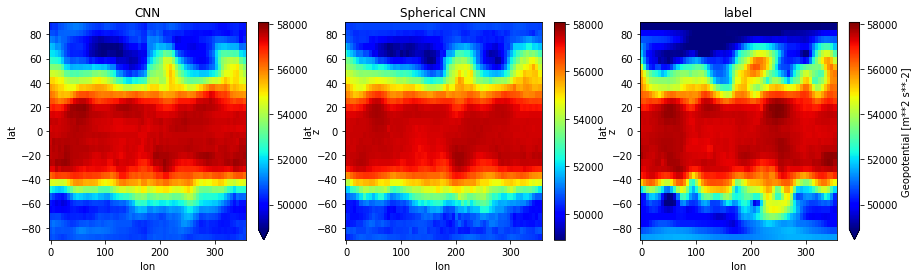

In [119]:
f, axes = plt.subplots(1, 3, figsize=(15, 4))

pred2.isel(time=6).z.plot(ax=axes[0], vmin = min_, vmax= max_, cmap='jet')
axes[0].set_title('CNN')
pred.isel(time=6).z.plot(ax=axes[1], vmin = min_, vmax= max_, cmap='jet')
axes[1].set_title('Spherical CNN')
valid.isel(time=6).z.plot(ax=axes[2], vmin = min_, vmax= max_, cmap='jet')
axes[2].set_title('label')

plt.show()

In [120]:
def compute_rmse(da_fc, da_true, mean_dims=xr.ALL_DIMS):
    """
    Compute the RMSE with latitude weighting from two xr.DataArrays.
    Args:
        da_fc (xr.DataArray): Forecast. Time coordinate must be validation time.
        da_true (xr.DataArray): Truth.
    Returns:
        rmse: Latitude weighted root mean squared error
    """
    error = da_fc - da_true
    rmse = np.sqrt(((error)**2).mean(mean_dims))
    if type(rmse) is xr.Dataset:
        rmse = rmse.rename({v: v + '_rmse' for v in rmse})
    else: # DataArray
        rmse.name = error.name + '_rmse' if not error.name is None else 'rmse'
    return rmse

In [121]:
print(compute_rmse(pred, valid).load())

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z_rmse   float32 895.49475
    t_rmse   float32 3.9456558


In [122]:
print(compute_rmse(pred2, valid).load())

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z_rmse   float32 811.4612
    t_rmse   float32 3.5355818
